In [10]:
from jax0planet.oblate import OblateSystem, OblateBody, OblateTransitOrbit
from jax0planet.light_curve import oblate_lightcurve

from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit
import jax
import jax.numpy as jnp

In [11]:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2, 0.1, 0.1]),
          'f':0.,
          'bo':0.8,
          'duration':0.4,
          'theta':0.
}

orbit = TransitOrbit(
    period=params['period'], time_transit=0., duration=params['duration'], impact_param=params['bo'], radius=params['radius']
)
oblate_orbit = OblateTransitOrbit(
    period=params['period'], time_transit=0., duration=params['duration'], impact_param=params['bo'], radius=params['radius'], f=params['f'], theta=params['theta']
)

t = jnp.linspace(-0.3, 0.3, 200)
lc = limb_dark_light_curve(orbit, params['u'])(t)

oblate_lc = oblate_lightcurve(orbit=oblate_orbit, u=params['u'])(time=t)
params['radius'] = params['radius']/jnp.sqrt(1-params['f'])
legacy_oblate_lc = legacy_oblate_lightcurve(params, t=t)

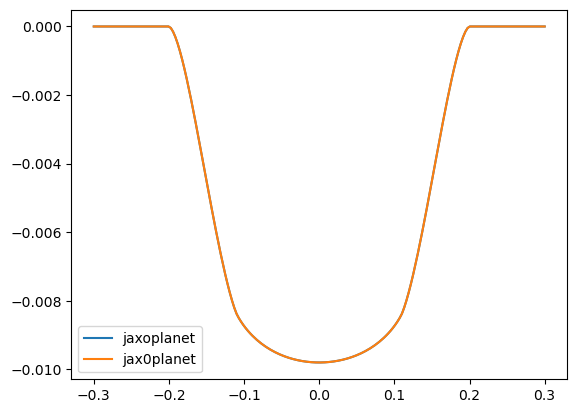

In [12]:
import matplotlib.pyplot as plt
plt.plot(t, lc, color="C0", label='jaxoplanet')
plt.plot(t, oblate_lc-1., color="C1", label='jax0planet')
plt.legend()

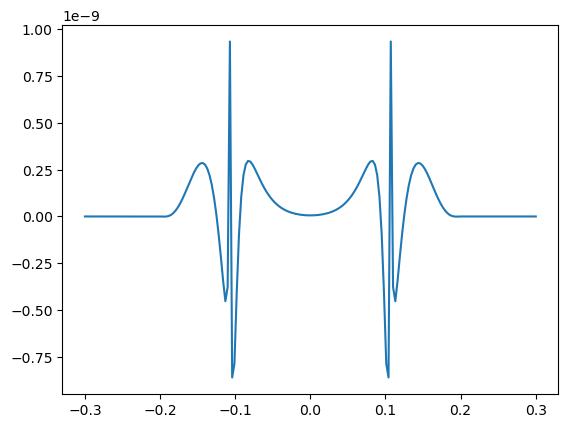

In [13]:
plt.plot(t, lc-(oblate_lc-1.))

In [14]:
from jaxoplanet.orbits.keplerian import Central
central = Central(radius=1.0, mass=0.8)
oblate_system = OblateSystem(central).add_body(
    radius=0.1, mass=0.1, period=300.456, f=0.0, theta=10.0
)

In [15]:
oblate_lc_system = oblate_lightcurve(orbit=oblate_system, u=params['u'])(time=t)

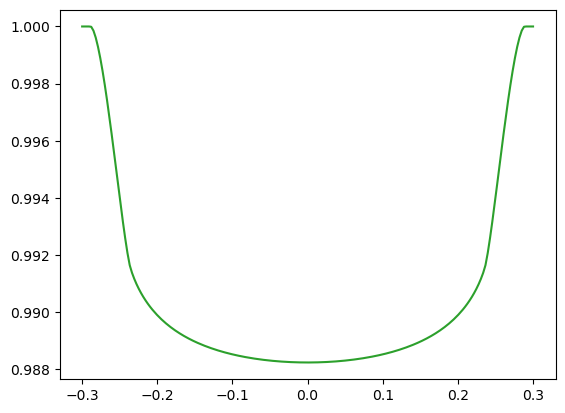

In [16]:
plt.plot(t, oblate_lc_system, color="C2", label='jax0planet system')

## Testing out exposure time integration:

In [17]:
from jaxoplanet.light_curves.transforms import integrate
from jaxoplanet.units import unit_registry as ureg
lc_integrated = integrate(oblate_lightcurve(orbit=oblate_orbit, u=params['u']), exposure_time=1*ureg.hour)

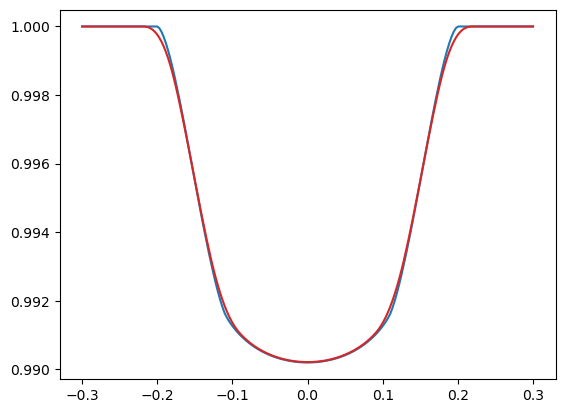

In [18]:
oblate_lc_integrated = lc_integrated(time=t)
plt.plot(t, oblate_lc)
plt.plot(t, oblate_lc_integrated, color="C3", label='jax0planet integrated')